## 2. Fasea: Algoritmoak diseinatzen

#### [Ikasle]

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, hiru algoritmo diseinatu beharko dituzue. Lehenengoa, algoritmo eraikitzaile bat izango da. Bigarrena, soluzio bakarrean oinarritutako heuristiko bat izan beharko du, eta azkenik, hirugarrena algoritmo poblazional bat izango da. Hiru algoritmoak estokastikoak izan beharko dute, eta horietatik, bik, oinarri probabilistikoa izan beharko dute. Adibidez, Simulated Annealing, Estimation of Distribution Algorithms (EDAk) edota Ant Colony Optimization (ACO) implementatu ditzazkezue. Proiektu honen kasuan, algoritmoen helburua, komunitate kopuru jakin bat emanik, modularitatea maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.

#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena fluxu diagrama eta sasikode bat egitea direla. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Azalpenak ere nahi ditut. Diagramak ez dira eurak bakarrik azaltzen, beraz testutik erreferentziatu egin beharko dituzue. Saiatu idazkera zientifiko-tekniko batekin idazten (pentsatu publikatuko duzuen lan bat dela). Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

# Grafoa kargatzea

Azpiko kodearen bidez grafo orijinala kargatu daiteke. 

In [ ]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

from pdb import set_trace

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

#Numpy
import numpy as np

#Random
import random

from google.colab import drive
drive.mount('/content/drive')

def sortu_grafoa():

    connect = sqlite3.connect('/content/drive/MyDrive/BH/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)
    
    G = nx.Graph()

    for p, a in df.groupby('paper_id')['name']:
      for u, v in itertools.combinations(a, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] +=1
        else:
          G.add_edge(u, v, weight=1)
    return G

GO = sortu_grafoa()
print(GO.nodes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Nan Li', 'Rong Jin', 'Zhi-Hua Zhou', 'Fajwel Fogel', "Alexandre d'Aspremont", 'Milan Vojnovic', 'Nisheeth Srivastava', 'Ed Vul', 'Paul R. Schrater', 'Sewoong Oh', 'Devavrat Shah', 'Siu On Chan', 'Ilias Diakonikolas', 'Rocco A. Servedio', 'Xiaorui Sun', 'Aaron van den Oord', 'Benjamin Schrauwen', 'Robert A. Vandermeulen', 'Clayton Scott', 'Qiang Liu', 'Alexander T. Ihler', 'Joseph G. Makin', 'Philip N. Sabes', 'Isabel Valera', 'Zoubin Ghahramani', 'Kumar Dubey', 'Qirong Ho', 'Sinead A. Williamson', 'Eric P. Xing', 'Anqi Wu', 'Mijung Park', 'Oluwasanmi O. Koyejo', 'Jonathan W. Pillow', 'Balaji Lakshminarayanan', 'Daniel M. Roy', 'Yee Whye Teh', 'Jason Chang', 'John W. Fisher III', 'Mehmet G?nen', 'Adam A. Margolin', 'Qichao Que', 'Mikhail Belkin', 'Yusu Wang', 'Bo Dai', 'Bo Xie', 'Niao He', 'Yingyu Liang', 'Anant Raj', 'Maria-Florina F. Balcan', 'Le Song', 'K

# Aurreprozesaketa

Eman zaigun datubaseak bi arazo nagusi zituen gero azalduko diren algoritmoak aplikatze aldera: 

* Grafoko nodo bakoitza string batek identifikatzen du. String baten bidezko identifikazioa ez da komenigarria bektore moduan adieraziko diren soluzioentzat. Formalizazioan esan dugun bezala, guk nodo bakoitza bektoreko posizio baten bidez adierazten dugu eta beraz, eragiketak azkartzeko, posizio hori eta grafoan nodoak duen identifikazioa berdina izatea komeni zaigu.

* Grafoko nodo guztiak ez daude lotuta, nodoen eskualde isolatuak daude. Datuak gehiago aztertuta, konturatu gara eskualde horien artetik gehienak oso txikiak direla (nodo bat, bi edo hirukoak), baina badirela bete batzuk handi samarrak (60 nodotik gorakoak handienak). Sortu nahi dugun partizio kopurua zein izan, agian beharrezkoa ziango da multzo isolatu handi horietatik batzuk kontuan hartzea.

Bi arazo horiei aurre egiteko aurreprozesaketa sistema bat sortu dugu, azpiko kodearen bidez egiten dena. Labur esanda, bi aldaketa nagusi egiten dizkio hasierako grafo orijinalari: nodoen identifikazio-stringak zenbaki osoak bihurtzen ditu, soluzioen bektorean dagokien posizioarekin bat datoztenak; eskatzen zaion k partizio kopuruaren arabera bazertuko edo onartuko ditu multzo isolatuak, haien nodo kopuruak atalase-balio bat (k-ren mendekoa) gainditzen duen edo ez begiratuz. Baztertzen diren multzoetako autoreak, gerora, zero partiziokoak (partizio nulukoak) bezala aurkeztuko dira.  

Grafo aurreprozesatuak soluzio-bektoreak txikiago egitea ahalbidetzen ditu (1843koak izan beharrean 500-800 bitartekoak) eta eragiketak egitea azkartu, hortaz. 

In [ ]:
#Sarrera: G grafo orijinala, k sortu nahi den partizio kopurua
#Irteera: G grafo aurreprozesatua, kodeak hiztegia, pisuakGuztira grafo prozesatuko pisuen batura eta verbose exekuzioari buruzko informazioa duen zerrenda. 
def prozesatu_grafoa(G,k,weight = 'weight'):

    GO = G.copy() #Kopiatu grafo orijinala.

    kodeak = { } #Hasieratu string-zenbaki oso erreferetziak izango dituen hiztegia. 
    pisuakGuztira = 0 #Grafoko ertzen pisuen batura gordeko duen aldagaia hasieratu. 
    
    multzoak = [ ] #Grafoko multzo isolatuak gordeko dituen zerrenda hasieratu.
    aztertuGabeak = list(GO.nodes) #Nodo aztertu gabeen zerrenda hasieran nodo guztiek osatuko dute.
    ilara = [ ]
    verbose = [ ] #Exekuzioari buruzko informazioa biltzeko.
    ##1. FASEA: Grafoko multzo isolatuak topatu eta multzoak zerrendan gorde.
    while (len(aztertuGabeak) > 0): #Multzo guztiak identifikatzeko.
      unekoa = aztertuGabeak[0]  
      ilara.extend(GO.edges(unekoa))
      aztertuGabeak.pop(0)
      multzoa = [unekoa]
      while (len(ilara) > 0): #Zabalerako korritzea erabiltzen da. Multzo baten nodoak identifikatu.
        unekoa = list(ilara.pop(0))[1]
        if (unekoa in aztertuGabeak):
          ilara.extend(GO.edges(unekoa)) #Uneko nodoaren ertzak gehitu ilarara
          aztertuGabeak.remove(unekoa) #Aztertu gabeetatik kendu unekoa.
          multzoa.append(unekoa)
      multzoak.append(multzoa)
    
    #2. FASEA: Zein multzo baztertu erabakitzea.
    listaHandienaTam = len(max(multzoak, key = len)) #Topatu den multzo handienaren nodo kopurua. 
    verbose.append(listaHandienaTam)
    baztergarritasuna = listaHandienaTam/k #Multzo bat baztertua izango da atalase balio hau gainditzen ez badu, hau da, multzo handienaren tamaina zati partizio kopurua.
    verbose.append(baztergarritasuna)
    kendu = [ ]
    maxim=0 
    for i in multzoak: #Atalasea baino txikiagoak diren multzoak baztertzea. Baztertuko diren multzoen nodoak kendu zerrendan bildu. 
      if (len(i) < baztergarritasuna):
        kendu.extend(i)
        if (len(i) > maxim): #Verbose-rentzat, baztertu den multzo handienaren tamaina eskuratzeko.
          maxim=len(i)

    verbose.append(maxim)

    mantenNodo = len(G.nodes) - len(kendu) #Mantenduko den nodo kopurua kalkulatu. 
    kont=0

    #3. FASEA: Baztertzea erabaki den multzoak baztertu.
    for i in kendu:
      GO.remove_node(i) #Multzoaren nodoa ezabatu.
      kodeak[i]=mantenNodo+kont  #Kodeak hiztegian zenbaki oso bat esleitu baztertua izango den nodo honi, baina onartuak izan direnen ondoren. Izan ere, nodo honek ez du edukiko posiziorik soluzio-bektoreetan.
      kont+=1

    #4. FASEA: Onartu diren multzoen nodoei soluzio-bektoreko posizio bat esleitu eta posizio horren zenbaki osoa ipini haien grafoko identifikazio bezala. 
    kont=0
    for i in GO.nodes: #Grafo prozesatuko nodo bakoitzarentzat
      if (i not in kodeak): 
        ertzak=GO.edges(i) #Eskuratu haren ertzak
        for j in ertzak:
          pisuakGuztira+=GO[j[0]][j[1]][weight] #Modularitatean erabiliko den parametroa eguneratu, grafo prozesatuko pisuen batura.
        kodeak[i]=kont #Hiztegian nodoaren identifikazioaren berri eman.
        mapping = {i:kont} #Grafoko nodoen izen aldaketa egiteko.
        kont+=1
        GO = nx.relabel_nodes(GO, mapping) #Grafoko nodoen izen aldaketa egiteko.

    return GO, kodeak, pisuakGuztira, verbose

k=10
G, kodeak, pisuakGuztira, verbose = prozesatu_grafoa(GO,k)
print("GRAFO AURREPROZESATUAREN XEHETASUNAK: ")
print("\nOrijinalaren nodo kopurua: ",len(GO.nodes))
print("Aurreprozesatuaren nodo kopurua: ",len(G.nodes))
print("Multzo handienaren tamaina: ",verbose[0])
print("Bazterketa-tamaina: ",verbose[1])
try:
  print("Baztertu den multzorik handienaren tamaina: ",verbose[2])
except:
  print("Ez da multzorik baztertu.")
print("\n\nKodeak: ",kodeak)
print("Nodo orijinalak: ",GO.nodes)
print("Nodo aurreprozesatuak: ",G.nodes)

GRAFO AURREPROZESATUAREN XEHETASUNAK: 

Orijinalaren nodo kopurua:  1843
Aurreprozesatuaren nodo kopurua:  661
Multzo handienaren tamaina:  531
Bazterketa-tamaina:  53.1
Baztertu den multzorik handienaren tamaina:  36


Kodeak:  {'Nan Li': 661, 'Rong Jin': 662, 'Zhi-Hua Zhou': 663, 'Tianbao Yang': 664, 'Chao Qian': 665, 'Yang Yu': 666, 'Fajwel Fogel': 667, "Alexandre d'Aspremont": 668, 'Milan Vojnovic': 669, 'Dan Alistarh': 670, 'Jennifer Iglesias': 671, 'Nisheeth Srivastava': 672, 'Ed Vul': 673, 'Paul R. Schrater': 674, 'Siu On Chan': 675, 'Ilias Diakonikolas': 676, 'Rocco A. Servedio': 677, 'Xiaorui Sun': 678, 'Moritz Hardt': 679, 'Ludwig Schmidt': 680, 'Eric Price': 681, 'Cynthia Dwork': 682, 'Vitaly Feldman': 683, 'Toni Pitassi': 684, 'Omer Reingold': 685, 'Aaron Roth': 686, 'Alexandr Andoni': 687, 'Piotr Indyk': 688, 'Thijs Laarhoven': 689, 'Ilya Razenshteyn': 690, 'Will Perkins': 691, 'Santosh Vempala': 692, 'Aaron van den Oord': 693, 'Benjamin Schrauwen': 694, 'Robert A. Vanderm

Azpian ikus daiteke grafo aurrepozesatuaren irudikapen grafiko bat.

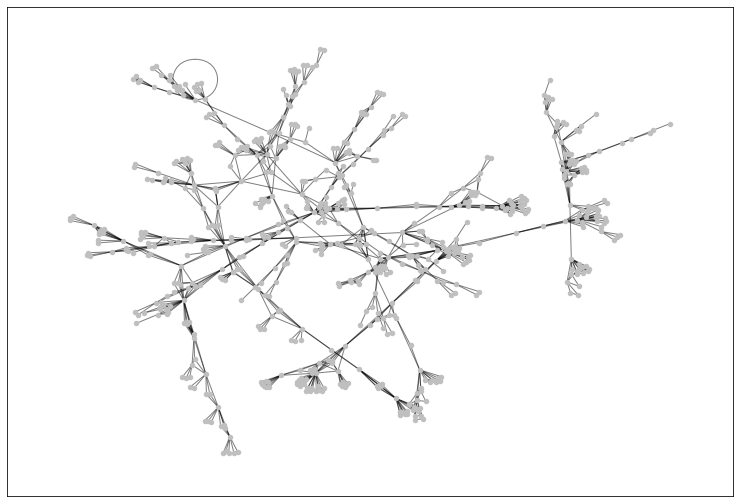

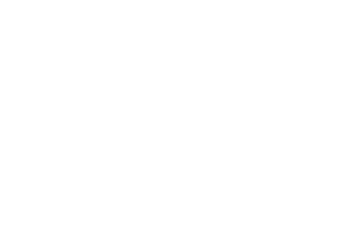

In [ ]:
#Draw graph
plt.figure(figsize=(13, 9))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75')
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
plt.show()

plt.axis('off')
plt.show()

# Bilaketa espazioa eta helburu-funtzioa

In [ ]:
# pip install ipynb exekutatu liburutegi hau erabili ahal izateko.
from itertools import product
import community
import networkx as nx
import numpy as np
import random

#Partizio baten kanpo eta barne pisuak kalkulatzen ditu
def parPisuak (G,soluzioa,k,weight = 'weight'):
  kideak = np.where(soluzioa == k)[0] #K partizioko kideak lortu
  bpisuak = 0
  kpisuak = 0
  for i in range(len(kideak)): #Kide bakoitzerako
    ertzak = G.edges(kideak[i]) #Bere mugakideak eskuratu
    for j in ertzak:
      if (j[1] in kideak): #Mugakidea uneko partizioko kidea bada
        bpisuak+=G[kideak[i]][j[1]][weight] #Barne pisuetara
      else: #Ez bada
        kpisuak+=G[kideak[i]][j[1]][weight] #Kanpo pisuetara
  return(bpisuak/2,kpisuak) #Barne pisuak zati bi egin behar dira, nodo batetik bestera iritsi bada, alderantziz ere egin delako. Kanpo pisuen kasuan ez, kanpoko nodotik barrukorako ertza ez delako aztertu.  

def modularitatea(G, soluzioa, pisuakGuztira):
  partizioKop=max(soluzioa)+1
  modularitateak = [ ]
  #0 partizioan ahalik eta nodo gutxien egotea nahi dugu, zigortu, beraz, partizio honetan sailkatzea.
  for i in range(1,partizioKop):
    bpisuak, kpisuak = parPisuak(G,soluzioa,i)
    modularitateak.append(bpisuak/pisuakGuztira - ((kpisuak + 2*bpisuak)/(2*pisuakGuztira))**2)
  return sum(modularitateak)


Soluzio bat bideragarritzat hartu dugu bi baldintza hauek betetzen baditu:

* Zehatz-mehatz k partizio baditu.
* Komunitate bakoitzak gutxienez bi kide baditu.

In [ ]:
def soluzioa_bideragarria_da (soluzioa,partizio_kopurua,grafoa):
  partizio_kop = max(soluzioa)+1 #Partizio kopurua
  #ZIURTATU: Eskatutako partizio kopurua eta soluzioak dituenak bat datozela. 
  if (partizio_kop != partizio_kopurua):
    #print("SOLBID: Soluzioa ez da bideragarria. Eskatutako partizio kopuruaren desberdina.",partizio_kop,partizio_kopurua)
    return(False)
  partizioen_elem_kop = np.zeros(partizio_kop) #Partizio bakoitzean dagoen autore kopurua
  #ZIURTATU: komunitate bakoitzean gutxienez bi pertsona daude. 
  for j in range(len(soluzioa)): #Soluzio bakoitzerako
    if (soluzioa[j] >= 0): #Uneko autorearen partizio-zenbakia baliozkoa bada. Autore bakartia bada hau -2 izango da.
      partizioen_elem_kop[soluzioa[j]]+=1 #Batu bat uneko autoreari esleitu zaion partizioan
  if (sum(partizioen_elem_kop < 2) >= 2): #Partizioren batek autore bat edo gutxiago baditu, soluzioa ez da bideragarria. (0 partizioak posible du ez eduki kiderik)
    return(False)
  return(True)

#Algoritmo eraikitzailea

Problema honek grafoa hainbat esparrutan banatzea eskatzen du eta esparru guztiek dute beti puntu zentral bat. Ideia horretatik abiatu ginen algoritmo eraikitzailea sortzeko. Azpiko algoritmo eraikitzaileak ausaz aukeratzen ditu k puntu grafoan zehar eta horietatik abiatuta, partizioak eratzen hasten da. Hasierako puntu batek berarekin lotuta dauden puntuak partizio bereko egingo ditu, eta hauek ere haiekin lotura duten puntuak partizio bereko egingo dituzte, eta horrela errekurtsiboki. Hau da, puntu batek bere partizioa "kutsatzen" die ingurukoei. Puntu bakoitzari behin bakarrik esleitu dakioke partizio bat, horri esker saihesten dugu partizio batek besteak desagertaraztea, haien puntuak berridatziz. 

Algoritmo hau bisualki ikus daiteke esteka hauetan: 

* K=4 | https://drive.google.com/file/d/1h4A0hhFaHxmJhdU8PnBEuH7zlu0xTfaA/view?usp=sharing

* K = 10 | https://drive.google.com/file/d/1lYZqjuyEQi4sgDZ8srzzpsRpLlc5Ib1b/view?usp=sharing

* K = 50 | https://drive.google.com/file/d/1Xzvbvv_lM_fp6FlheRcLkT9JCRIleHB7/view?usp=sharing

Esteka horretan hiru GIF aurkezten dira, aurkezten ari garen algoritmoaren exekuzioa erakusten dutenak. Fotograma bat ekoitzi da hamar iterazioko eta lehen irudian k=4 partizio sortzeko eskatu zaio, bigarrenean hamar partizio sortzeko eta azkenekoan berrogeita hamar sortzeko. Kontuan hartu behar da, batez ere lehen irudiaren kasuan, nahiz eta badirudien hiru partizio sortu dituela, laugarrena grafo aurreprozesatuan gehitu ez diren nodoentzat dela. 

**Irudietatik ateratako ondorioak**

* Hiru irudietan ikus daiteke hasierako puntuak nahiko urruti egon ohi direla elkarrengandik eta partizio gehienek nodoetan zehar hedatzeko aukera daukatela, nahiz eta batzuek nodo gehiago bereganatu besteek baino.

* k = 50en kasuan, partizio asko sortzea eskatzen zaionez, grafo aurreprozesatuan sartu diren zenbait multzori (txikienak normalean) ez zaizkie partiziorik esleitzen, hasiera punturik ez zaielako ipini probabilitatearengatik. 

**Algoritmoaren propietateak**

Algoritmo honek soluzio onak sortu ohi ditu k gehienetan (handietan ere bai). Gainera, bere soluzio guztiek propietate hauek betetzen dituzte:

* Beti dira bideragarriak. Soluzio bat bidergarri izateko gutxienez bi nodoz osatutako partizioak eduki behar ditu, hori bermatuta dago beti. Berme hori lortzeko algoritmoak hasierako puntuaz gain hasierako puntu bakoitzarentzat haren ondoko nodo bat erreserbatzen du eta partizio bera esleitu, hala, partizio bakoitzak ziurtasunez bi nodo edo gehiago edukiko ditu. Ez badu topatzen hasierako puntu horri erreserbatzeko nodorik, beste hasierako puntu bat bilatuko du.

* Bideragarria izateaz gain, beti komunitate kohesionatuak sortuko ditu. Komunitate kohesionatu gisa hartzen dugu komunitateko edozein nodotik, behar adina barne ertz erabiliz, komunitateko beste edozein nodotara iritsi daitekeen komunitatea. Gure hasierako formalizazioaren arabera, komunitate guztiek beti izan beharko lukete kohesionatuak eta algoritmo gehienekin halako komunitateak lortzen saiatzen gara. Algoritmo eraikitzaile honek ordea beti sortuko ditu komunitate kohesionatuak, puntu zentral batetik hedatuz sortzen baititu. Honek balio gehigarria ematen die, helburu funtzioak ematen dienaz gain, algoritmo honek sortutako soluzioei. 

Ondorengo propietateak gehitzea ere pentsatu dugu algoritmo eraikitzaile honentzat eta zenbait proba egin ere bai, baina azkenean ez ditugu gehitu, azpian azaldutako arrazoiengatik. 

* **Algoritmoa behartzea grafoko multzo independente bakoitzari partizio bat gutxienez esleitzera**. Gure probleman, grafoak nodo multzo elkar-konektatu handi bat du (500-600 nodo artekoa) eta ondoren badira nodo multzo beste nodoekiko erabat isolatu txikiago batzuk (65 nodo ingurukoa handiena). Aurreprozesaketan multzo txiki gehienak ezbatzen ditugula esan dugu, baina k ertainetarako bigarren mailako multzo horien artetik handienak onartu ohi ditugu. K ertainetan ia beti egokituko da multzo guztietan hasierako puntu bat, probabilitate hutsarengatik, baina gertatu ohi da k handietan (30etik gora, adibidez) multzo batzuk hasierako punturik gabe gelditzea eta beraz, partizio nulua esleitu behar izatea multzo osoari (0 partizioa). Hori saihesteko pentsatu genuen metodo hau, baina baztertzea erabaki genuen, bi arrazoirengatik:

    * Multzo txiki bakoitzari gutxienez partizio bat esleitzen bazaio, k ertainetan agian hobekuntzaren bat egongo da, baina k handiagoetan multzo bakoitzak partizio bat eduki dezan k gehiegi "xahutuko" dira eta hortaz, gutxiago erabiliko dira benetan garrantzitsuak diren multzo handietan.
    * Algoritmoa hainbat aldiz exekutatuta antzeko emaitzak lor daitezke. 

* **Grafoaren pisu handiko guneetatik aukeratzea hasierako puntuak**. Ideia grafoari buruzko informazio bilketa bat egitea zen, algoritmoaren muina exekutatzen hasi aurretik. Bilketa horretan ertz pisutsuenak dituzten nodoak atzemango ziren eta horietan kokatu hasierako puntuak, izan ere, puntu horiek komunitate baten puntu zentral izateko aukera handiagoa dutela pentsatu genuen. Hala ere, askotan ertz pisutsudun nodoak elkarrengandik hurbil daude eta gainera, oinarrizko algoritmo eraikitzaileak zuen dibertsifikazio gaitasuna murrizten zaio, hasierako puntuak gehienetan berdinak hartuko baitzituen algoritmoak. 

* **Grafoko multzo bakandu bakoitzaren pisu-proportzioaren arabera partizio gehiago edo gutxiago inbertitzea multzo bakandu bakoitzean**. Grafoa multzo isolatuetan bantzea zen ideia eta bakoitzean zenbat partizioen hasiera puntu jartzea erabakitzea ausaz egin beharrean, multzoen ertzen batez besteko pisuen arabera egitea. Batez besteko pisu handia zuten multzoei partizio gehiago esleituko zitzaizkien eta gutxiago besteei. Grafoaren beste aurreprozesaketa bat gehiago eskatzen duenez, k handitu ahala moteldu egiten da algoritmoa, exekuzio bakoitza egiteko segundu batzuk hartzeraino k handietan. Espero genuenaren kontrara, ez zituen emaitza oso onik eman.


Laburbilduz, azpiko **algoritmoaren sasikodea** honakoa da:

* Hasieratu soluzioa.
* k partizio kopurua aldiz EGIN:
    * Partizioaren hasierako puntua esleitu arte EGIN:
        * Ausaz aukeratu grafoko nodo bat.
        * Egiaztatu aukeragarria dela eta ondoko nodo bat duela gutxienez.
    * BUKATU EGIN;
* BUKATU EGIN;
* Hasierako puntuak eta bere ondoko baten ertzak itxaron zerrendara gehitu.
* Itxaron zerrenda hutsik ez dagoen arte EGIN:
    * Barajatu itxaron zerrenda.
    * Hautatu itxaron zerrendako lehen elementua eta ezabatu bertatik.
    * Elementu hori aurkitu duen nodoaren partizioa esleitu elementuak adierazten duen nodoari.
    * Nodo horren ingurukoak itxaron zerrendara gehitu.
* BUKATU EGIN;
* Partiziorik esleitu ez zaien nodoei partizio nulua (0) esleitu.

In [ ]:
def sortu_soluzioa (grafoa,k):
  ausazko_hasieraPuntuak = [ ] #Partizio bakoitzaren nukleoa
  soluzioa = np.full(len(grafoa.nodes),-1) #Hasieran soluzioak -1 balioak bakarrik ditu, autore esleitu gabeak.
  for i in range(1,k): #Partizio kopurua adina aldiz
    while True: #Hasierako nodo egokiak aurkitu arte egin
      puntua = random.randint(0,len(grafoa.nodes)-1) #Hautagai bat sortu
      if (puntua not in ausazko_hasieraPuntuak and len(list(grafoa.edges(puntua))) > 0 and soluzioa[list(grafoa.edges(puntua))[0][1]] == -1 and soluzioa[puntua] == -1): #Hautagaiak ez du jada aukeratuta egon behar. Hautagaiak gutxienez lotura bat eduki behar du (partizio bakoitzak gutzienez 2 kide). Hautagaiak duen loturen artetik guxtienez bat ez da izan behar beste hasiera puntu bat edo haren ondoko erreserbatu bat. Gainera, hasierako puntuak ezin du beste hasierako puntu batek erreserbatuta egon.  
        ausazko_hasieraPuntuak.append(puntua) #Gehitu hasierako puntua
        unekoa = list(grafoa.edges(ausazko_hasieraPuntuak[i-1])) #Eskuratu bere loturak
        soluzioa[unekoa[0][1]]=i #Erreserbatutako hasiera puntuaren ondoko nodoa i partiziokoa egin
        soluzioa[ausazko_hasieraPuntuak[i-1]]=i #Hasiera puntua i partiziokoa egin
        break #Bukatu uneko partizioaren hasierako puntuaren bilaketa
  #HASIERAKO PUNTUEN HEDAPENA
  itxaron_zerrenda = [ ] #Exekuzioa antolatuko duen ilara hasieratu 
  for i in range(1,k): #Hasierako puntu bakoitzarentzat
    itxaron_zerrenda.append((i,grafoa.edges(ausazko_hasieraPuntuak[i-1]))) #Gehitu bere ondoko nodoak itxaron zerrendara
    itxaron_zerrenda.append((i,grafoa.edges(list(grafoa.edges(ausazko_hasieraPuntuak[i-1]))[0][1]))) #gehitu hasierako puntuaren ondoko erreserbatuaren mugakide nodoak ere zerrendara, bide esklusiboak izan ditzakeelako.
  while len(itxaron_zerrenda) > 0: #Itxaron zerrendan zerbait dagoen bitartean
    random.shuffle(itxaron_zerrenda) #Itxaron zerrenda barajatu, partizio bakarra ez dadin hedatu uneoro grafoan barrena.
    unekoarenErtzakElem = itxaron_zerrenda.pop(0) #Ilarako lehenengo elementua hautatu eta kendu
    unekoarenErtzak = list(unekoarenErtzakElem[1]) #Elementu honek 2 zati ditu, iturburuko elementuaren partizioa [0] eta iturburu horretatik zeuden loturak [1]. Loturak eskuratu.
    for i in unekoarenErtzak: #Lotura bakoitzerako egin:
      if (soluzioa[i[1]] == -1): #Loturak adierazten duen nodoak oraindik partiziorik ez badu esleituta:
        soluzioa[i[1]]=unekoarenErtzakElem[0] #Elementu honen partizioa esleitu. 
        itxaron_zerrenda.append((unekoarenErtzakElem[0],grafoa.edges(i[1]))) #Nodo honetara iritsi garen lehen aldia denez, itxaron zerrendara gehitu bere loturak eta iturburuaren partizioa.
  for i in range(len(soluzioa)): #Baliteke grafoak loturarik gabeko nodoak edukitzea
    if soluzioa[i] == -1: #Haietara oraindik ez da inoiz iritsi algoritmoa
      soluzioa[i]=0 #Esleitu 0 izeneko partizioa, partizio nulua 
  return(soluzioa) #Itzuli soluzioa

sortu_soluzioa(G,k)

array([5, 5, 6, 6, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9,
       4, 4, 4, 9, 9, 9, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 8, 8, 8, 5,
       5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 7, 7, 7, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 1, 1, 1, 4, 4, 5, 5, 5, 5, 6,
       6, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 7, 7, 7, 2, 2, 2,
       9, 9, 9, 9, 3, 3, 3, 2, 2, 5, 5, 9, 9, 9, 9, 4, 5, 5, 5, 7, 7, 7,
       6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 5, 5, 9, 9, 9, 9, 5, 5, 5, 9, 9, 2, 2, 4, 4,
       4, 7, 7, 7, 4, 4, 4, 4, 6, 6, 5, 5, 5, 4, 4, 5, 5, 5, 9, 9, 9, 4,
       4, 4, 7, 7, 7, 7, 2, 2, 2, 4, 4, 4, 4, 4, 4,

Azpiko kodeak algoritmo eraikitzailea hainbat aldiz exekutatzen du eta exekuzio guzti horietan lortutako soluziorik onena itzuli. 0.459 inguruko fitness-a duen soluzio bat lortzen du 1000 aldiz exekutatuta.

In [ ]:
def eraikitzaile_search (G,iterazioak,k,pisuakGuztira):
  sol_onena = sortu_soluzioa(G,k)
  fitness_onena = modularitatea(G,sol_onena,pisuakGuztira)
  print("Hasiera: ",fitness_onena)
  for i in range(iterazioak):
    hautagaia = sortu_soluzioa(G,k)
    fitness_hautagaia = modularitatea(G,hautagaia,pisuakGuztira)
    if (fitness_hautagaia > fitness_onena and soluzioa_bideragarria_da (hautagaia,k,G)):
      fitness_onena=fitness_hautagaia
      sol_onena=hautagaia
      print("Hobekuntza: ",fitness_onena, "iterazioa: ",i)
  return(fitness_onena,sol_onena)

fitness_onena, sol_onena = eraikitzaile_search(G,1000,k,pisuakGuztira)
print(fitness_onena,sol_onena)

Hasiera:  0.38394386070849934
Hobekuntza:  0.4022783100354865 iterazioa:  0
Hobekuntza:  0.41950093089640034 iterazioa:  3
Hobekuntza:  0.43074993482480245 iterazioa:  5
Hobekuntza:  0.4377224590641201 iterazioa:  9
Hobekuntza:  0.44719418815219575 iterazioa:  12
Hobekuntza:  0.4493152062519498 iterazioa:  15
Hobekuntza:  0.45141971729779706 iterazioa:  28
Hobekuntza:  0.4559261430143486 iterazioa:  33
Hobekuntza:  0.45642089354066073 iterazioa:  83
Hobekuntza:  0.4564713368841635 iterazioa:  169
Hobekuntza:  0.4565699642258021 iterazioa:  376
Hobekuntza:  0.45705756784329993 iterazioa:  377
Hobekuntza:  0.457298303397622 iterazioa:  379
Hobekuntza:  0.4589200061712405 iterazioa:  847
0.4589200061712405 [4 4 3 3 7 7 7 7 7 7 7 7 9 9 9 3 3 3 3 3 3 3 7 7 7 3 3 3 8 8 2 2 1 1 1 1 1
 1 7 7 8 8 8 2 2 5 5 5 7 7 7 7 7 7 5 5 5 9 9 9 7 7 7 7 7 7 7 7 7 7 2 2 2 7
 7 7 6 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 8 8 8 7 7 7 9 9 9 9 5 5 5 2 2 2 2 2 9
 9 1 1 1 1 2 2 2 8 8 8 5 5 5 7 7 4 4 8 8 3 3 7 5 2 2 2 2 2 4 2

# Random Search

Gure algoritmoek hobetu beharko luketen oinarri-soluzioa zein den jakiteko, Random Search algoritmoa inplementatu dugu azpian eta ikusi daiteke 1000 iteraziorekin 0.045eko fitness-a duen soluzio bat ematen duela. 

In [ ]:
def random_search(G,k,it,pisuakGuztira):
  i=0
  best_fitness = float("-inf")
  best_solution = np.zeros(len(G))
  while i < it:
    sol_berria = np.random.randint(1,k,len(G))
    fitness_berria = modularitatea(G,sol_berria,pisuakGuztira)
    if fitness_berria > best_fitness:
      best_solution = sol_berria
      best_fitness = fitness_berria
    i+=1
  return best_solution, best_fitness

best_solution, best_fitness = random_search(G,k,1000,pisuakGuztira)
print(best_solution,best_fitness)


[9 1 7 5 8 2 4 2 6 7 6 4 5 1 1 1 5 1 4 9 4 6 9 1 7 4 6 3 7 2 5 3 3 7 3 1 6
 5 8 9 3 6 6 1 3 4 6 2 4 4 3 9 9 6 8 6 1 6 8 8 8 5 8 7 8 9 1 2 7 3 9 2 9 1
 4 4 1 1 5 1 2 1 6 5 9 7 5 6 3 9 3 9 7 7 3 9 9 6 1 2 6 1 9 2 4 4 8 4 6 1 5
 4 4 5 7 4 4 3 3 4 6 3 8 7 3 8 4 5 1 8 5 9 3 4 9 4 3 4 7 1 6 9 6 9 3 8 5 2
 2 8 9 9 6 4 6 7 2 5 7 2 1 1 5 4 7 1 7 4 4 3 9 8 4 1 1 1 2 8 8 7 4 7 4 5 5
 4 5 3 5 4 9 2 2 4 9 8 7 2 2 3 4 4 7 1 9 4 4 2 6 4 2 5 1 1 6 9 8 7 6 6 6 7
 1 1 8 3 3 6 4 7 2 7 7 8 4 8 8 3 1 1 4 3 5 6 7 5 1 1 1 2 7 3 9 1 3 2 9 1 1
 6 4 6 5 6 2 3 5 3 9 8 2 1 4 6 9 1 5 3 2 3 3 2 3 6 4 6 4 4 9 8 4 3 8 6 9 4
 1 6 3 6 5 1 5 1 5 3 9 2 6 1 6 4 6 6 4 8 7 8 7 4 7 7 4 9 9 9 2 8 5 6 5 4 5
 1 5 5 8 6 6 6 5 7 3 9 5 1 7 5 4 2 8 2 4 1 4 9 8 2 5 2 6 7 2 1 8 6 9 7 6 1
 8 8 6 2 2 4 6 7 2 7 1 4 2 8 6 1 8 8 9 3 7 4 1 5 2 9 7 9 8 8 4 8 7 6 4 7 7
 7 7 7 2 1 5 4 8 2 6 3 2 1 8 9 7 8 7 1 1 1 6 1 3 8 8 9 8 4 3 2 7 7 2 5 2 3
 9 5 7 9 7 8 1 6 7 7 8 2 9 8 1 1 2 2 9 9 6 4 2 6 1 7 9 4 4 8 6 2 9 2 4 1 8
 9 7 5 5 3 9 7 2 2 1 1 4 

# Bilaketa lokalak

## Suberaketa simulatua

CDP problemari aurre egiteko egokia izan daitekeen algoritmoetako bat Suberaketa Simulatua da. Algoritmo honen aldeko apustua egitea erabaki genuen dibertsifikazioan duen gaitasun handiarengatik. Gure bilaketa-espazioa menditsua da, minimo lokal ugarikoa, horregatik, interesgarria iruditu zitzaigun soluzio kaskarragoak onartzen dituen algoritmo bat inplementatzea, ingurune gehiago erabiltzen dituztenak (VNDa adibidez) edo hasierako soluzio anitzekoak (ILS adibidez) baino. Inguruneak eskuratzeko funtzio batzuk nahiko motelak izan daitezke, batez ere hautaketa-irizpide bezala greedy metodoa erabiltzen badute. Intuizioa erabiliz, gainera, hamming bezalako aldaketa gutxi eragiten dituzten inguruneak VND motako algoiritmoetan bigarren mailako gisa erabiltzea (dugun soluzio onena hobekuntza txikien bidez doitzeko) ideia ona izan daitekeen arren, kontrako alde bat aurkitu diogu: aldaketa txikiak eragiten dituztenez, minimo lokaletik irteteko aukera gutxi dituzte eta hori ingurune malkartsuetan kaltegarria izan ohi da. Soluzio txarragoak onartzen dituzten algoritmoek aldiz, aukera handiagoa dute minimo lokaletatik ateratzeko kasu honetan, pazientzia egokia ipintzen bazaie.

Suberaketa simulatuak ez ditu hautaketa-irizpideak erabiltzen, ausaz aukeratzen du soluzio bat ingurune batetik. Honek denbora aurreztu ohi du bilaketa-espazio malkartsuetan. Zalantzak eduki genituen Suberaketa simulatuaren ingurunea hautatzerako orduan eta hainbat proba egin genituen swap eta hamming inguruneekin. Insert ingurunea hasieratik baztertu genuen, haren handitasunak motelegia egiten baitu. Bi inguruneek antzeko garapena dute hasierako soluzioetan: hamming-en kasuan nodo bakarrari eta swap-en kasuan bi nodori aldatuko zaizkie partizioak iterazioko. Alabaina, swap komenigarriagoa izan daiteke, ez duelako eskatzen soluzioen bideragarritasuna egiaztatzea iterazio bakoitzean, partizioen trukeak partizio guztiek beti nodo kopuru berdinarekin mantentzen baititu (bakoitzak gutxienez bi edukiko ditu, beraz). Hamming-en kasuan bideragarritasuna egiaztatu behar da, baina soluzio aniztasun handiagoa eskaintzen du trukean, partizioek haien nodo kopuruak alda ditzaketelako. Hala ere, CDP probleman nodo kopuru antzekoko soluzioak egokiagoak izan ohi dira. Bi inguruneekin egin ditugu probak. 

Gure Suberaketa simulatuaren algoritmoak honako ezaugarriak ditu:

* Tenperaturaren eguneraketa: tenperatura oreka lortzen den iterazio bakoitzean eguneratzen da. Eguneraketa hori egiteko funtzio geometriko bat erabiltzen dugu. Modu horretan lortzen dugu tenperatura oso altuko iterazio gutxi egotea (dibertsifikazio iterazioak) eta tenperatura baxuko asko (esplotaziorako denbora utzi), atalase baliora iristeko iterazio bakoitzean pauso txikiagoak emango baititu funtzioak. Kontuan hartu behar da iterazio bat aipatzen dugunean oreka lortu den iterazio bat dela eta oreka hori lortzeko askoz soluzio gehiago aztertu beharko direla tenperatura altua denean, aukera gutxi izango delako soluzioak baztertzeko. Tenperatura baxua denean aldiz, kontrakoa gertatuko da eta horregatik, iterazio gehiago utzi behar dizkiogu algoritmoari esplotazio prozesua burutu dezan. 

* Oreka baldintza: gure algoritmoan iterazio batean oreka lortu dela esango dugu baldin eta aurkitutako soluzio onena hobetu zuen azken soluzioa aztertu ondoren, n iterazio igaro badira. N hori algoritmoaren parametro bat izango da, erabiltzaileak zehaztu beharko duena. Parametro hori zenbat eta handiagoa izan, orduan eta azterketa gehiago burutuko ditu algoritmoak (soluzio hobeak topatuz, gehienetan), denbora gehiago behar izatearen truke.

* Gelditze irizpidea: tenperaturaren eguneraketa egiteko funtzio geometrikoak erabiltzen direnean ia ezinbestekoa da gelditze irizpidean tenperatura minimoko atalase bat edukitzea. Gure gelditze irizpideak atalase bat emanda, uneko tenperatura hura baino baxuagoa den kalkulatuko du eta hala bada, exekuzioa geldituko du. 

* Soluzioaren onarpen irizpidea: Suberaketa simulatua inplementatzen duten programa guztiek irizpide bat eduki behar dute soluzio hautagai bat onartu edo ez ebaluatzeko. Onartzen bada, soluzio hori erabiliko da hurrengo iterazioetan (oreka lortu arte) hurrengo hautagaiak eta haien ingruuneak topatzeko. Bestela, aurreko soluzioaren ingurunearekin jarraituko du programak. Gure kasuan, onarpen irizpidea Suberaketa simulatuaren algoritmo orijinalean proposatutakoaren antzekoa da, hau da, onartutako azken soluzioaren egokitasuna eta hautagaiarenaren arteko diferentzia (energia diferentzia) kalkulatzen da eta hura energiaren funtzioari aplikatzen zaio. Funtzio horren emaitza izango da hautagaia onartua izateko probabilitatea, diferentzia handitu ahala txikiagoa. 

**Algoritmoaren sasikodea** honakoa da:

* Sarrerak: hasierakoBeroa (hasiera-tenperatura), hoztuDa (tenperatura minimoa, gelditze-atalase balioa), atalasea (oreka lortzeko hobekuntzarik ekarri behar ez duten soluzio kopurua), G (grafo aurreprozesatua), k (partizio kopurua) eta pisuakGuztira (grafoko ertzen pisuen batura).
* Irteerak: soluzio onenaren helburu funtzioaren balioa eta soluzio onena.

-----------

* Hasieratu tenperatura, soluzio onena, iterazio kontagailuak, eta abar.
* BITARTEAN not gelditzeIrizpidea EGIN:
    * Hasieratu iterazioa eta oreka.
    * Kalkulatu uneko soluzio onenaren ingurunea.
    * BITARTEAN not orekaBaldintza EGIN:
        * Ausaz aukeratu soluzio bat uneko ingurunetik.
        * BALDIN soluzioa orain arteko onena ORDUAN:
            * Gorde.
            * Eguneratu ingurune onenaren aldagaia.
            * Oreka kontagailua hasieratu.
        * BESTELA BALDIN soluzioaOnartuBeharDa ORDUAN:
            * Eguneratu ingurunea soluzioaren ingurunea ipiniz. 
            * Oreka kontagailua eguneratu.
        * BESTELA:
            * Oreka kontagailua eguneratu.
        * BUKATU BALDIN;
    * BUKATU EGIN;
    * Eguneratu tenperatura.
    * Eguneratu gelditze irizpidearen kontagailua.
* BUKATU EGIN;

In [ ]:
import math
import random as rm
def eguneratuTenperatura (hasierakoT,oraingoT,iterazioa):
  oraingoT = hasierakoT / (iterazioa+1)
  return(oraingoT)

def gelditu (tenperatura,minimoa):
  if (tenperatura < minimoa):
    return(1)
  return(0)

def orekaLortuDa (hobekGabe,atal):
  if (hobekGabe > atal):
    return(1)
  return(0)

def soluzioaOnartuBeharDa (hautagaia,hautagaiaF,onartuaF,tenperatura):
  energia_diferentzia = onartuaF - hautagaiaF
  onarpena = math.exp(-energia_diferentzia/ tenperatura)
  #print(hautagaiaF, onartuaF, onarpena)
  return(onarpena)

In [ ]:
#SWAP INGURUNEA
#Swap inguruneak soluzioko edozein digitu beste edozeinekin trukatuta sor
#daitezkeen soluzio guztiak barne hartzen ditu.
def swap_ingurunea(sol,G,k):
  soluzioak = []
  for i in range(len(sol)):
    for j in range(i+1,len(sol)): #i-n dagoen elementua j-n jarri eta j-n dagoena, i-n
      if (sol[i] == sol[j]):
        continue
      nes = sol.copy()
      a = nes[i]
      nes[i] = nes[j]
      nes[j] = a
    if (soluzioa_bideragarria_da(sol,k,G)):
      soluzioak.append(nes)
  return soluzioak

#Bilaketa lokalaren inguruneak eratzeko honako funtzioak erabili daitezke:
#HAMMING INGURUNEA
#Hamming inguruneak uneko soluzioari digitu bat aldatuta sor daitezkeen
#soluzio guztiak barne hartzen ditu.
def hamming_ingurunea(sol,G,k):
  solutions = []
  for i in range(len(sol)): #soluzioko elementu bakoitzerako
    s = sol.copy()
    for j in range(1,k+1):
      s[i] = j
      if soluzioa_bideragarria_da(sol,k,G): #soluzioa bideragarria bada, ingurunean sartu
        solutions.append(s)
  return solutions

def  suberaketaSimulatua (hasierakoBeroa,hoztuDa,atalasea,G,k,pisuakGuztira):
  kont = 0 #Lehen begiztaren iterazio kontagailua
  tenperatura = hasierakoBeroa #Tenperatura gordeko duen aldagaia
  best_solution = np.random.randint(1,k,len(G.nodes)) #Soluzio onena ausazko hasierako soluzio bat da
  best_fitness = modularitatea(G,best_solution,pisuakGuztira) #Helburu funtzioaren bidez ausazko soluzio horren egokitasuna neurtuko dugu
  uneko_sol = best_solution #begizta barruan erabiltzeko aldagaiak
  uneko_fitness = best_fitness #uneko iteraziora arte aurkitu den soluzio onena (bigarren begiztan), ez du zertan inoizko onena izan
  aurrekoIngurunea = swap_ingurunea(best_solution,G,k) #Inguruneak birziklatu eta kalkuluak aurrezteko, beti erabili berri den ingurunea gorde.
  ingurune_onena = aurrekoIngurunea #Ingurune onena gorde, kalkuluak aurrezteko lehen iteraziotik bigarrenera igarotzean.
  while (gelditu(tenperatura,hoztuDa) == 0): #Gelditze irizpidea, tenperatura minimora iritsi gara?
    hobekGabe=0 #Bigarren begiztari hasiera eman ahal izateko, hobekGabe behar bezala hasieratu
    aurrekoIngurunea = ingurune_onena #Aurreko ingurunea hasieratu orain arteko soluzio onenaren gordetako ingurunearekin, bigarren begizta ingurune horretan hasiko baita.
    hautagaia= best_solution
    uneko_sol = best_solution
    while (orekaLortuDa(hobekGabe,atalasea) == 0): #Oreka irizpidea, ez da soluzio hoberik aurkitu atalasea iterazioetan?
      hautagaia = random.choice(aurrekoIngurunea)
      hautagaia_fitness = modularitatea(G,hautagaia,pisuakGuztira) #Uneko inguruneko soluziorik onenaren egokitasuna neurtu
      onartu = soluzioaOnartuBeharDa (hautagaia,hautagaia_fitness,best_fitness,tenperatura) #Soluzioa onargarria den edo ez begiratu
      if (onartu > 1): #Hala bada eta gainera, inoizko onena bada
        best_solution=hautagaia #Soluzio onena bezala hartu
        best_fitness=hautagaia_fitness
        uneko_sol = hautagaia
        uneko_fitness = hautagaia_fitness
        ingurune_onena = swap_ingurunea(best_solution,G,k) #Ingurune berria kalkulatu, zeina ingurune onena ere izango den
        aurreko_ingurunea = ingurune_onena  
        hobekGabe=0 #Hobekuntza bat gertatu da, berrabiarazi oreka-kontagailua, 0 iterazioetan jarraian aurkitu dira unekoa baino soluzio hobeak
        print("Hobekuntza:",best_fitness)
      elif (rm.random() < onartu): #Soluzioa ez bada inoizko onena, baina onartzea erabaki bada
        uneko_sol = hautagaia
        uneko_fitness = hautagaia_fitness
        hobekGabe+=1 #Ez da hobekuntzarik lortu iterazio honetan, beraz, iterazio bat gehiago jarraian hobekuntzarik lortu gabe
        aurrekoIngurunea = swap_ingurunea(best_solution,G,k) #Hurrengo ingurunea kalkuatu, onartutako soluzioarena, hain zuzen 
        print("Okertu: ",uneko_fitness, " (",best_fitness,") ")
      else: #Soluzioa ez bada onartu
        hobekGabe+=1 #Hobekuntzarik gabeko beste iterazio bat
        print("Ukatu: ",hautagaia_fitness, " (",best_fitness,") ")
      #print(hautagaia)  
    kont+=1 #Tenperaturaren eguneraketarako, iterazio bat gehiago igaro da.
    tenperatura= eguneratuTenperatura(hasierakoBeroa,tenperatura,kont) #Tenperatura eguneratu, oreka lortu baita.
    print("\nOREKA AURKITU DA, tenperatura berria: ",tenperatura,". ",kont," iterazioa")
  return((best_fitness,best_solution))

best_fitness, best_solution = suberaketaSimulatua (2,0.005,50,G,k,pisuakGuztira)
print("BUKAERA: ",best_fitness,best_solution)

## Deabruaren algoritmoa

Goian aurkeztu dugun Suberaketa simulatuaren algoritmoa mota bereko beste algoritmo batekin alderatzeko, azpian dagoen Deabruaren algoritmoa inplementatu dugu. Algoritmo honek bilaketa lokal arrunt bat aplikatzen du soluzio hobe bat aurkitzeko gai ez den arte. Une horretan, pazientzia batez baliatuz, soluzio txarragoak onartzeko gai da. Onartzen duen soluzio txar bakoitzak bere pazientzia gutxituko du eta soluzio onago bat lortzeko gai ostera, bere pazientzia berriz igo egingo da. Pazientzia agortzen zaioenean bukatuko da algoritmoaren exekuzioa. 

Deabruaren algoritmoak honako ezaugarriak ditu:

* Pazientzia maximoa: soluzioak hobetzearen ondorioz pazientzia gehiegi ez handitzea du helburu bezala, bere pazientzia ez da inoiz pazientzia maximoa baino handiagoa izango. Problemaren arabera egokitu behar den parametro bat da.

* Best first aukeraketa-irizpidea: ingurune handiekin ari garenez greedy irizpidea ez da egokiena errendimendu aldetik eta gainera, ez du dibertsifikazioan laguntzen. Best first aukeratu dugu, beraz.

* Tabua: deabruen algoritmoek joera handia izan ohi dute soluzio txarrago bat onartu ondoren berriz ere aurreko soluzio onenera itzultzeko. Hori ekiditeko tabu bat ipini dugu (itzultzea debekatuta duen soluzioen zerrenda) eta erabiltzailearen esku utzi tabuaren tamaina zehaztea parametro bidez. 

**Algoritmoaren sasikodea** honakoa da:

* Hasieratu soluzioak, tabua eta pazientzia.
* BALDIN pazientzia > 0 EGIN:
  * Kalkulatu soluzioaren ingurunea. 
  * Ingurunea barajatu (Best first irizpideari laguntzeko eta ausazkotasuna handitzeko).
  * Aukeratu soluzio bat ingurunetik.
  * BALDIN soluzioa_fitness > onena_fitness EGIN:
    * Eguneratu soluzio onena.
  * BESTELA:
    * Soluzioa onartu.
  * BUKATU BALDIN;
  * Eguneratu pazientzia.
  * Eguneratu tabua.
* BUKATU EGIN;

In [ ]:
#Soluzioa tabuan dagoen edo ez itzultzen du. Baldin badago TRUE, bestela FALSE.
def tabuanDago (soluzioa,tabua):
    return(any([(soluzioa == a).all() for a in tabua]))

#Ingurunea, aurreko soluzioaren fitness-a, tabua, grafoa eta pisuakGuztira sartuta, hurrengo soluzioa eta haren fitness-a itzultzen ditu.
def best_first (ingurunea,aurrekoa_fitness,tabua,G,pisuakGuztira):  
  hauta = ingurunea[0] #Lehen soluzioa hautatu (okerragoak onartzeko), hasieraketa
  aFit = modularitatea(G,hauta,pisuakGuztira)
  for i in range(1,len(ingurunea)): #Sarrerakoa baino soluzio onago bat aurkitu arte, egin:
    fitness = modularitatea(G,ingurunea[i],pisuakGuztira)
    if fitness > aurrekoa_fitness and not tabuanDago(ingurunea[i],tabua): #Hobea bada eta ez badago tabuan, onartu.
      return(fitness, ingurunea[i])
    elif fitness > aFit and random.random() < 0.5 and not tabuanDago(ingurunea[i],tabua): #Lehenago iterazioetako onena baino hobea bada, gorde
      aFit = fitness
      hauta = ingurunea[i]
  return(aFit,hauta) #Ez bada sarreran sartu dena baino soluzio hoberik aurkitu, inguruneko onena itzuli (greedy)

#Deabruaren pazientzia eguneratu, sartutako dif diferentziaren arabera. 
def ahuldu (energia,pazientziaMax,dif): 
    energia=energia + dif
    if (energia > pazientziaMax): 
        energia=pazientziaMax
    return(energia)

#Tabuan soluzioa soluzioa gehitu, tokirik ez badago lehendik zegoen zaharrena ezabatu. 
def eguneratuTabua (soluzioa,tabua,tabuTam):
    if (len(tabua) == tabuTam):
        tabua.pop(0)
    tabua.append(soluzioa)
    return(tabua)

#SWAP INGURUNEA
#Swap inguruneak soluzioko edozein digitu beste edozeinekin trukatuta sor
#daitezkeen soluzio guztiak barne hartzen ditu.
def swap_ingurunea(sol,G,k):
  soluzioak = []
  for i in range(len(sol)):
    for j in range(i+1,len(sol)): #i-n dagoen elementua j-n jarri eta j-n dagoena, i-n
      if (sol[i] == sol[j]):
        continue
      nes = sol.copy()
      a = nes[i]
      nes[i] = nes[j]
      nes[j] = a
    if (soluzioa_bideragarria_da(sol,k,G)):
      soluzioak.append(nes)
  return soluzioak

#DEABRUA
#Deabru honek energia egin duen hobekuntzaren
#arabera irabazi edo okerkuntzaren arabera galtzen du. Soluzio bat beste bat baino 10 puntu hobea bada, 10 energia-puntu irabaziko
#ditu deabruak. 
def deabrua (pazientziaMax,tabuTam,G,k,pisuakGuztira):
    energia = pazientziaMax #Hasieran deabruak energia maximoa du.
    tabua = [ ] #Hasieran tabua hutsa dago.
    aurreko_sol=np.random.randint(1,k,len(G.nodes)) #Begizta barruan erabiltzeko aldagaiak
    best_solution=aurreko_sol  #Soluzio onena ausazko hasierako soluzio bat da
    best_fitness=modularitatea(G,best_solution,pisuakGuztira) #Helburu funtzioaren bidez ausazko soluzio horren egokitasuna neurtuko dugu
    aurrekoa_fitness=best_fitness
    kont=0
    while (energia > 0):
        ingurunea = swap_ingurunea (aurreko_sol,G,k) #Ingurunea kalkulatu
        random.shuffle(ingurunea) #Barajatu, best first-i laguntzeko.
        hautagaia_fitness, hautagaia = best_first(ingurunea,aurrekoa_fitness,tabua,G,pisuakGuztira) #Inguruneko soluzioen artetik aurrekoa hobetzen duen lehena hautatu
        dif=hautagaia_fitness-aurrekoa_fitness #Soluzioen arteko diferentzia kalkulatu
        if (hautagaia_fitness > best_fitness): #Soluzioa inoizko onena bada:
            best_fitness=hautagaia_fitness #Eguneratu aldagaiak
            best_solution=hautagaia
            aurreko_sol=hautagaia
            aurrekoa_fitness=hautagaia_fitness
            print("Hobekuntza: ",best_fitness," Energia: ",energia)
        else: #Bestela
            aurreko_sol=hautagaia #Soluzio txarragoa onartu.
            aurrekoa_fitness=hautagaia_fitness
            print("Pausoa: ",hautagaia_fitness,"(",best_fitness,")"," Energia: ",energia)
        energia=ahuldu(energia,pazientziaMax,dif) #Energia eguneratu, handitu edo txikitu.
        tabua = eguneratuTabua(aurreko_sol,tabua,tabuTam) #Tabura gehitu uneko soluzio-hautagaia.
        kont+=1 
        #sortuFotograma(aurreko_sol,kont,k,pos)
    return(best_fitness,best_solution)

print(deabrua(0.2,30,G,k,pisuakGuztira))

## Inguruneak

In [ ]:
#Bilaketa lokalaren inguruneak eratzeko honako funtzioak erabili daitezke:
#HAMMING INGURUNEA
#Hamming inguruneak uneko soluzioari digitu bat aldatuta sor daitezkeen
#soluzio guztiak barne hartzen ditu.
def hamming(sol,G,k):
  solutions = []
  for i in range(len(sol)): #soluzioko elementu bakoitzerako
    s = sol.copy()
    s[i] = s[i]+1 #0tik 1era pasatu edo 1etik 0ra pasatu
    if soluzioa_bideragarria_da(s.tolist(),G,k): #soluzioa bideragarria bada, ingurunean sartu
      solutions.append(s)
    s[i] = s[i] - 2
    if (s[i] >= 0 and soluzioa_bideragarria_da(s.tolist(),G,k)):
      solutions.append(s)
  return solutions

## Hautaketa irizpideak

In [ ]:
def greedy (ingurunea,G,pisuakGuztira):
  best_fitness = modularitatea(G,ingurunea[0],pisuakGuztira)
  best_sol = ingurunea[0]
  for i in range(1,len(ingurunea)):
    fitness=modularitatea(G,ingurunea[i],pisuakGuztira)
    if fitness > best_fitness:
      best_fitness = fitness
      best_sol = ingurunea[i]
  return best_fitness, best_sol

def best_first (ingurunea,aurrekoa_fitness,G,pisuakGuztira):
  for i in ingurunea:
    fitness = modularitatea(G,i,pisuakGuztira)
    if fitness > aurrekoa_fitness:
      return(fitness,i)
  return(aurrekoa_fitness,ingurunea[0])

## Bilaketa Lokal arrunta

Bilaketa lokal arrunta exekutatzen duen programa bat sortu dugu azpian, ondorioak ateratzerako orduan sortu ditugun bilaketa lokal hedatuko algoritmoen emaitzekin alderatzeko. 

In [ ]:
def bilaketaLokala (it_max,G,pisuakGuztira,k):
  it_kop = 0
  best_solution = np.random.randint(1,k,len(G.nodes))
  best_fitness = modularitatea(G,best_solution,pisuakGuztira)
  print("Hasierako fitnessa:",best_fitness)
  while (it_kop < it_max):
    ingurunea = hamming(best_solution,k,G)
    hautagaia_fitness, hautagaia = best_first (ingurunea,best_fitness,G,pisuakGuztira)
    if (hautagaia_fitness > best_fitness):
      best_fitness=hautagaia_fitness
      best_solution=hautagaia
      print("Hobekuntza: ",best_fitness)
    else:
      print("Bukaera: ez da soluzio hoberik topatu.")
      return(best_fitness,best_solution)
  print("Bukaera: iterazio kopuru maximora heldu naiz.")
  return (best_fitness,best_solution)

best_fitness, best_solution = bilaketaLokala(1000,G,pisuakGuztira,k)
print("Soluzio onena: ", best_fitness,best_solution)

# Algoritmo Genetikoa


CDP problema ebazteko baita ere poblazioetan oinarritutako algoritmoak implementatu ditugu. Hasteko oinarrizko algoritmo genetiko baten bidez problema ebazten saiatu gara. Algoritmo genetikoaek egitura finko bat jarraitzen hautaketa, gurutzaketa, mutazioa eta eguneraketa. Hortik habiatuta fase bakoitzak era askotan inplementa daitezke metodo sinpleenetatik konplexuenera. Horregaitik, guk uste dugunez algoritmoaren funtzionamendua ondo ulertzeko nahian fase desberdinen diseinua intuizioa erabili dugu eta ez teknika oso konplexuak. Diseinatutako teknikak ondokoak izan dira. 

Hasteko, lehen populazioa sortzeko auzasko bektoreekin hasieratzen dugu. Ondoren, hautaketa egiteko populazioaren %50 hoberenak hartzen ditugu. Hauekin gurutzaketa eta mutazioa burutzen ditugu. Gurutzaketa egiteko bi soluzio desberdin hartzen ditugu eta ondorengo gurutzaketa aplikatzen dugu bi soluzio berri sortzeko.
Soluzioak 4 zatitan banatzen ditugu eta laurden horien konbinaketatik sortaraziz soluzio berriak. Lehen soluzio berria honako zatiak konkatenatzen ditu: 1.soluzioaren 3.laurdena, 2.soluzioaren 4.laurdena, 2.soluzioaren 2.laurdena eta 1.soluzioaren 1.laurdena. Era berean bigarren soluzio berria lortzeko lehenengo soluzio berria egiteko erabili ez ditugun laurden zatiak orden berean baina soluzio kontrakoarenak, hau da, 2.soluzioaren 3.laurdena, 1.soluzioaren 4.laurdena, 1.soluzioaren 2.laurdena eta 2.soluzioaren 1.laurdena.
Gurutzaketa egin ondoren, mutazioa aplikatzen diegu gurutzaketa prozesutik lortutako soluzioei. Mutazioa gertatzeko 0.9-eko mutazio tasa izanda, soluzioaren posizio bat ausaz aukeratzen dugu eta beste balio bat jarriz, hau da, beste partizio batean. Azkenik uneko populazioa, gurutzaketan gurasoak izan direnak, eta mutazio prozesuaren ondoren lortutako emaitza guztien artetik hoberenak hartzen ditugu, finkatutako populazio tamaina adina, eta populazioa eguneratzen dugu.


**Algoritmoaren sasikodea** honakoa da:

* Mutazio_tasa hasieratu
* Hasierako populazioa hasieratu, soluzio guztiak bideragarriak direla zihurtatuz
* Iterazio kopuru maximora ailegatu arte EGIN:
  * Uneko populazioaren hoberenak lortu, hautaketa funtzioaren biidez
  * Populazioaren hoberenekin gurutzaketa egin, gurutzaketa funtzioa erabiliz
  * Mutazio tasaren arabera mutazioa aplikatu gurutzatutako soluzio multzoetara
  * Iterazio hasieran zeuden soluzioak(gurasoak) eta mutazio prozesuaren ondoren(gurutzaketa + mutazioa) lortutako soluzio guztiak multzokatu
  * Soluzio guzti horietatik hoberenak aukeratu populazio tamaina adina, eguneraketa fiuntzioari deituz
* Bueltatu soluzio hoberena eta modularitatea

In [ ]:
# Funtzio honek populazioaren %50 hoberenak bueltatzen ditu
# populazioa parametroa soluzioen lista bat den
# G parametroa problemaren grafoa da
# pisuakGuztira parametroa grafoko ertz guztien pisuen balioen gehiketa adierazten du
def hautaketa(populazioa,G,pisuakGuztira): # Populazioaren %50 hoberenak hautatuko ditugu
  size = len(populazioa)
  populazioa.sort(reverse=True, key= lambda x: modularitatea(soluzioa=x,G=G,pisuakGuztira=pisuakGuztira)) 
  hoberenak = populazioa[0:int(size/2)]
  return hoberenak #bueltatu %50

# Funtzio honek bi soluzioen artean gurutzaketa egiten du soluzio bakoitza 
# 4 zatitan banatuz eta zati horiek konbinatu bi soluzio berri lortzeko
# 1 soluzio berria: 1.soluzioaren 3.laurdena, 2.soluzioaren 4.laurdena, 2.soluzioaren 2.laurdena eta 1.soluzioaren 1.laurdena
# 2 soluzio berria: 2.soluzioaren 3.laurdena, 1.soluzioaren 4.laurdena, 1.soluzioaren 2.laurdena eta 2.soluzioaren 1.laurdena
def gurutzatu(sol1,sol2):
  n = len(sol1)   
  c1 = int(n*0.25) # 1. laurdena
  c2 = int(n*0.5)  # 2. laurdena
  c3 = int(n*0.75) # 3. laurdena

  # sol1 4 zatitan banatu
  s1_0 = sol1[0:c1]
  s1_1 = sol1[c1:c2]
  s1_2 = sol1[c2:c3]
  s1_3 = sol1[c3:n]
  
  # sol2 4 zatitan banatu
  s2_0 = sol2[0:c1]
  s2_1 = sol2[c1:c2]
  s2_2 = sol2[c2:c3]
  s2_3 = sol2[c3:n]
  
  new_sol1 = []
  # s1_2 s2_3 s2_1 s1_0
  new_sol1.extend(s1_2)
  new_sol1.extend(s2_3)
  new_sol1.extend(s2_1)
  new_sol1.extend(s1_0)
  new_sol1 = np.asarray(new_sol1, dtype= int)

  new_sol2 = []
  # s2_2 s1_3 s1_1 s2_0
  new_sol2.extend(s2_2)
  new_sol2.extend(s1_3)
  new_sol2.extend(s1_1)
  new_sol2.extend(s2_0)  
  new_sol2 = np.asarray(new_sol2, dtype= int)

  return new_sol1, new_sol2

# Funtzio honek populazio baten soluzio guztien arteko gurutzaketa egiten du, beti ere soluzio berria bideragarria bada
# populazioa parametroa soluzioen lista bat den
# G parametroa problemaren grafoa da
# pisuakGuztira parametroa grafoko ertz guztien pisuen balioen gehiketa adierazten du
def gurutzaketa(populazioa,k,G): # Populazioaren gurutzaketa
  new_populazioa = []
  for i, sol1 in enumerate(populazioa):
    sol1 = np.asarray(sol1)
    for sol2 in populazioa[i+1:]:
      sol2 = np.asarray(sol2)
      new_sol1, new_sol2 = gurutzatu(sol1,sol2)
      if soluzioa_bideragarria_da(new_sol1,k,G): #ZIURTATU gurutzaketa bideragarria dela
        new_populazioa.append(new_sol1)
      if soluzioa_bideragarria_da(new_sol2,k,G): #ZIURTATU gurutzaketa bideragarria dela
        new_populazioa.append(new_sol2)
  
  return new_populazioa 

# Funtzio honek soluzio bati mutazioa aplikatzen dio, mutazioa bideragarria bada soluzio berria bueltatuko du bestela soluzioa berdin
# sol parametroa mutazioa aplikatu nahi diogun soluzioa
# k parametroa komunitate kopurua da
# G parametroa problemaren grafoa da
def mutazioa(sol,k,G):  # Soluzioaren ausazko posizio batean ausazko balioa esleitu
  n = len(sol)
  new_sol = sol
  i = random.randint(0,n-1) # soluzioaren posizioa ausaz
  a = random.randint(1,k) # Komunitate balioa ausaz
  komunitate = new_sol[i]
  while komunitate == a: # ZIURTATU komunitate desberdinera aldatu dugula 
    a = random.randint(1,k)
  new_sol[i] = a
  if soluzioa_bideragarria_da(new_sol,k,G): # ZIURTATU mutazioa bideragarria dela
    return new_sol                            
  return sol                                # bestela mutazioa ez egin eta soluzioa berdin bueltatu

# Funtzio honek soluzio multzo baten soluzio hoberenak bueltatzen ditu, populazio tamaina adina soluzio bueltztuko ditu
# soluzioa_multzoa parametroa soluzio multzoa da hoberenak lortu nahi dituguak
# populazio_tamaina parametroa lortu nahi ditugun soluzio hoberenen kantitatea, hasierako populazio tamaina normalean
# G parametroa problemaren grafoa da
# pisuakGuztira parametroa grafoko ertz guztien pisuen balioen gehiketa adierazten du
def eguneraketa(soluzioa_multzoa,populazio_tamaina,G,pisuakGuztira): # Hoberenak eguneratzeko
  soluzioa_multzoa.sort(reverse=True, key= lambda x: modularitatea(soluzioa=x,G=G,pisuakGuztira=pisuakGuztira)) 
  hoberenak = soluzioa_multzoa[0:populazio_tamaina]
  return hoberenak

In [ ]:
# populazio_tamaina parametroa populazioaren tamaina adierazten du
# it_max parametroa algoritmoak egin behar dituen iterazioen kopurua adierazten du
# G parametroa problemaren grafoa da
# pisuakGuztira parametroa grafoko ertz guztien pisuen balioen gehiketa adierazten du
# k parametroa soluzioak zenbat komunitatetan banatuta egotea nahi dugun adierazten du
def algoritmo_genetikoa_basikoa(populazio_tamaina, it_max,G,pisuakGuztira,k):
  mutazio_tasa = 0.9    
  kont = 0
  pop_unekoa = []
  # Populazioa sortu 'populazio_tamaina'-koa
  while kont != populazio_tamaina:
    sol = np.random.randint(1,k,len(G.nodes))
    if soluzioa_bideragarria_da(sol,k,G): # ZIURTATU soluzioa bideragarria dela
      pop_unekoa.append(sol)
    kont += 1
  
  # LOOP (it_max)
  for iterazioa in range(it_max):
    pop_hoberenak = hautaketa(pop_unekoa,G,pisuakGuztira) # HAUTAKETA
    pop_gurutzatuta = gurutzaketa(pop_hoberenak,k,G) # GURUTZAKETA
    for i in range(len(pop_gurutzatuta)): # MUTAZIOA
      if random.random() <= mutazio_tasa:
        pop_gurutzatuta[i] = mutazioa(pop_gurutzatuta[i],k,G)
    pop_gurutzatuta.extend(pop_hoberenak) # batu gurasoak eta mutatu ondoreneko soluzio guztiak
    pop_unekoa = eguneraketa(pop_gurutzatuta,populazio_tamaina,G,pisuakGuztira) # EGUNERAKETA

    print(str(iterazioa+1)+ ". iterazioaren hoberena: ", modularitatea(G,pop_unekoa[0],pisuakGuztira),"\n")
    
  pop_unekoa.sort(reverse=True, key= lambda x: modularitatea(soluzioa=x,G=G,pisuakGuztira=pisuakGuztira)) # populazioa ordenatu lehenengoa hoberena izateko
  
  best_sol = pop_unekoa[0] # algoritmo genetikoak lortutako soluziorik hoberena
  best_fitness = modularitatea(G, best_sol, pisuakGuztira)

  return best_fitness, best_sol 

In [ ]:
best_fitness, best_solution = algoritmo_genetikoa_basikoa(100,100,G,pisuakGuztira,k)
print("Algoritmo genetikoaren soluziorik hoberena: " + str(best_fitness))
print(best_solution)

# UMDA

Problema ebazteko EDA bat probatu nahi genuen, zer nolako emaitzak ematen dituen ikusteko. Inplementatzeko sinpleena UMDA denez, hori aukeratu genuen. Orain erabili ditugun gehienak baino algoritmo mota sofistikatuagoa denez, soluzio onak ematea espero genuen.

Hemen, iterazio bakoitzean pop_size tamainako populazio bat dugu. Dugun distribuzio modeloa laginduz (hasieran modeloa uniformea da) hainbat soluzio berri sortzen ditugu. Populazioa eta soluzio berriak batzen ditugu eta hortik, populazio berri bat sortzeko, pop_size soluzio hoberenak aukeratzen ditugu. Populazio berria edukita, soluzioen atributuen frekuentziatik distribuzio modelo berri bat kalkulatzen dugu eta prozesua berriz hasten dugu. Hau iterazio maximo batera heldu arte errepikatzen dugu.  



Azpiko **algoritmoaren sasikodea** honakoa da:

* Banaketa modeloa hasieratu (banaketa uniformea)
* Banaketa modeloa laginduz pop_size tamainako populazioa eraiki
* Iterazio kopuru maximora ailegatu arte EGIN:
    * Pop_size/2 soluzio berri sortu banaketa modeloa laginduz
    * Populazioa eta soluzio berrien arteko pop_size soluzio hoberenekin populazio berria sortu
    * Banaketa modeloa eguneratu populazio berriko soluzioekin
* Populazioko soluzio hoberena bueltatu

In [ ]:
# Funtzio honek banaketa modelo bat lagintzen du soluzio berri bat sortzeko
# model parametroak soluzioa sortzeko laginduko den modeloa adierazten du (kasu honetan matrize bat)
# size parametroak soluzioaren tamaina adierazten du
def createSolution(model,size):
  sol_berria = [-1]*size # soluzioaren lista hasieratu
  for a,i in enumerate(model):
    p = np.random.uniform(0,1) # ausaz 0 eta 1 tarteko zenbaki bat sortu
    geh = 0 # gehiketa egiten joateko aldagaia
    for ind,j in enumerate(i):
      geh += j # geh aldagaiari orain arteko baloreak gehitu
      if p <= geh: # orain arteko baloreak ausazko zenbakia baino handiagoa edo berdina bada
        sol_berria[a] = ind + 1 # soluzioko a. elementuan tokatu zaion balioa jarri
        break
  return sol_berria # soluzio berria bueltatu

# Funtzio honek bi lista hartzen ditu parametro bezala eta soluzioak lista baloreak listaren arabera ordenatzen du
# soluzioak parametroak ordenatu nahi dugun lista adierazten du
# baloreak parametroak "soluzioak" lista ordenatzeko kontuan eduki behar diren balioak dituen lista adierazten du
def sortByModularity(baloreak,soluzioak):
  return [sol for _, sol in sorted(zip(baloreak, soluzioak))] #soluzioak lista baloreak listaren arabera ordenatu (soluzioak modularitateen arabera ordenatu)

In [ ]:
# G parametroa problemaren grafoa da
# pisuakGuztira parametroa grafoko ertz guztien pisuen balioen gehiketa adierazten du
# k parametroa soluzioak zenbat komunitatetan banatuta egotea nahi dugun adierazten du
# max_iter parametroa algoritmoak egin behar dituen iterazioen kopurua adierazten du
# pop_size parametroa populazioaren tamaina adierazten du
def EDA(G,pisuakGuztira,k,max_iter=50, pop_size=100):
  k = k-1 #komunitate bat gutxi kolaboratu duten autoreentzat erreserbatu dugu, beraz, bakarrik k-1 komunitate esleitu beharko ditugu hemen
  iter = 0 #iterazio kopurua hasieratu
  pop_size = pop_size #populazio tamaina hasieratu
  population = [] 
  avg = [] #batazbesteko modularitateen lista hasieratu
  hoberenak = [] #modularitate hobeen lista hasieratu
  prob_model = len(G)*[[1/k]*k] #hasierako probabilitate modeloa uniformea da. k komunitate daudenez, horietako bakoitza izateko 1/k probabilitatea dago
  for i in range(pop_size): #lehenengo populazioa sortu
      population.append(createSolution(prob_model,len(G))) #modeloa lagindu eta populazioan sartu

  while iter < max_iter: #iterazio maximora ailegatu ez den bitartean
    iter+=1
    print(f'{iter}/{max_iter}') #oraingo iterazioa idatzi

    nppop = np.array(population)
    s = len(nppop)
    for i,column in enumerate(nppop.T): #aldi berean populazioko soluzio guztiak elementuz-elementu zeharkatu
      vec = [0]*k
      for element in column: #komunitate bakoitza zenbat aldiz agertzen den kontatu
        vec[element-1] += 1/s #bektore honetan zenbatuko da komunitate bakoitza i. nodoari zenbat aldiz esleitu zaion populazioko soluzioetan
      prob_model[i] = vec #kalkulatutako modelo berria normalizatu eta probabilitate modeloa eguneratu

    soluzio_berriak = []
    for i in range(int(pop_size/2)): #pop_size/2 soluzio berri sortu
      sol = createSolution(prob_model,len(G)) #soluzio bat sortu
      soluzio_berriak.append(sol) #soluzio berrietan gorde

    extended_population = population.copy()
    extended_population.extend(soluzio_berriak) #soluzio berriak eta populazioa konbinatu
    
    pop_berrirako = []
    for i in range(len(extended_population)): #sortutako populazio handiagoko soluzio guztietarako
      pop_berrirako.append(modularitatea(G,np.array(extended_population[i]),pisuakGuztira)) #beraien modularitatea kalkulatu
    population = sortByModularity(pop_berrirako,extended_population)[int(pop_size/2):] #soluzio berrien eta populazioaren konbinaketaren arteko pop_size soluzio hoberenak populaziora pasatu

    ### Beheko kodea ez da beharrezkoa algoritmoaren ibilbidea irudikatu nahi ez bada
    # hoberena = []
    # fit_hoberena = float("-inf")
    # av = 0
    # for i in population: #iterazio bakoitzean soluzio hoberenaren modularitatea eta batazbesteko modularitatea kalkulatu grafikoa egiteko
    #   m = modularitatea(G,np.array(i),pisuakGuztira)
    #   av += m
    #   if m > fit_hoberena: #oraingo soluzioa orain arteko maximoa baino moduluaritate handiagoa badu, maximoa oraingoa da
    #     fit_hoberena = m
    #     hoberena = i
    # hoberenak.append(fit_hoberena) #modularitate hobeen lista
    # avg.append(av/len(population)) #populazioko batazbesteko modularitatearen lista
  hoberena = population[-1]
  return hoberena#, hoberenak, avg

best_solution = EDA(G,pisuakGuztira,k,300,100)
print(best_solution)
print(modularitatea(G,np.array(best_solution),pisuakGuztira))
# plt.plot(list(range(300)),best,avg)
# plt.show()

# Azken emaitza

Azpiko kodearen bidez goiko algoritmoekin sortutako soluzioak soluzio "erreal" bihurtu daitezke, hau da, partizio edo komunitate bakoitzean zein autore kokatu den jakin. 

In [ ]:
#Soluzio bat, kodeak hiztegia eta G grafo orijinala sartuta, komunitateak eta haien kideak inprimatzen ditu.
def eman_azken_emaitza (soluzioa,kodeak,G):
  partizioak = [ ] #Partizioen nodoak gordeko dituen zerrenda
  for i in range(max(soluzioa)+1): #Partizioak adieraziko dituzten zerrenda habiatuak
    partizioak.append([])
  for j in G.nodes: #Nodo guztietan egin:
    ind = kodeak[j] #Eskuartu haren indizea, aurreprozesaketan esleitua.
    if (ind >= len(soluzioa)): #Indize hori soluzioaren tamaina baino handiagoa bada
      partizioak[0].append(j) #Partizio nulura gehitu
    else: #Bestela dagokion partizioa, soluziokoaren araberakoa.
      partizioak[soluzioa[ind]].append(j)
  print("------------AUTOREEEN KOMUNITATEAK------------\n")
  for i in range(len(partizioak)): #Inprimaketak
      print("\n",i,". Komunitatea: ",len(partizioak[i])," kidez osatuta.\n")
      for j in range(len(partizioak[i])):
         print(j+1," - ",partizioak[i][j])   
  return(partizioak)

partizioak = eman_azken_emaitza(soluzioa,kodeak,GO)

# Ondorioak

Hurrengo entregarako utzi ditugu, exekuzioei buruz informazio gehiago dugunerako. 